# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете.

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.

In [ ]:
!pip install torchmetrics pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 61.6 MB/s eta 0:00:00


In [ ]:
import math
import os
import random
import sys
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(42)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2023-11-16 19:27:29--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2023-11-16 19:27:29--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc305ec22283f1be431da2372903.dl.dropboxusercontent.com/cd/0/get/CHpi2MOG6FpjJnlM2kU_49rc37BG3kgcOG-aK-qnJFI6ybzhsIsv67eKCDX-ALx6a03Fn1YEw-Hd8-3ps9N8c4d3cQ-Mr_UtiJW37Dq51vTaow3Dvx5tyHm6TxrSMQgpz7BKo7CHH-GyVyCp-BdU0OBq/file?dl=1# [following]
--2023-11-16 19:27:30--  https://uc305ec22283f1be431da2372903.dl.dropboxusercontent.com/cd/0/get/CHpi2MOG6FpjJnlM2kU_49rc37BG3kgcOG-aK-qnJFI6ybzhsIsv67eKCDX-ALx6a03Fn1YEw-Hd8-3ps9N8c4d3cQ-Mr_UtiJW37Dq

## Задание 0

### Подготовка данных

In [ ]:
seed_everything(42)

train_1 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_2 = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_3 = transforms.Compose(
    [
        transforms.RandomResizedCrop(64),
        #transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset_1 = ImageFolder('/content/dataset/dataset/train', transform=train_1)
train_dataset_2 = ImageFolder('/content/dataset/dataset/train', transform=train_2)
train_dataset_3 = ImageFolder('/content/dataset/dataset/train', transform=train_3)
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2, train_dataset_3])
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=2, shuffle=False)

In [ ]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

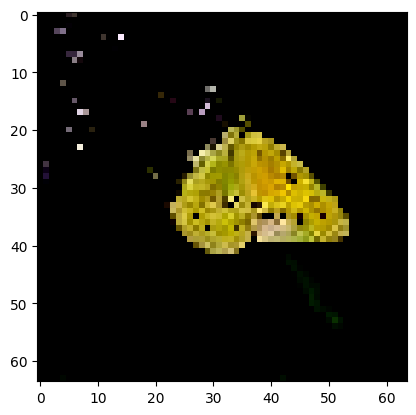

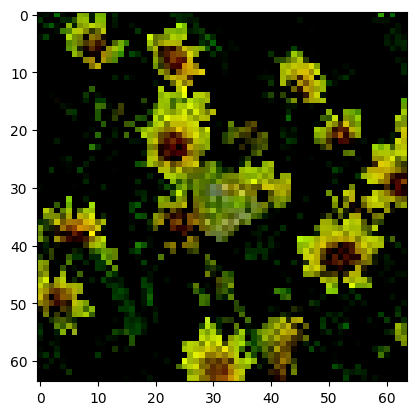

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[12].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[20].permute(1, 2, 0))
    plt.show()
    break

## Задание 1.

5 баллов

Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.

### Модель

In [ ]:
from torchvision.models import resnet18

model = resnet18(weights=None, num_classes=200)
optimizer = torch.optim.Adam(model.parameters(), 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=list(range(10, 20)), gamma=0.8)

### Вспомогательные функции для обучения

ну, в общем, we go hard or we go home, поэтому напишем-ка функции для обучения сами...

In [ ]:
def fit(model, train_loader, optimizer, criterion, scheduler = None):

  total_loss = 0.0
  total_accuracy = 0.0

  model.train()

  for x, y in tqdm(train_loader):
    pred = model(x.to(device))
    print('before loss')
    loss = criterion(pred, y.to(device))
    print('after loss')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += loss.item()
    print('before acc')
    total_accuracy += (pred.cpu().argmax(1) == y).float().mean()
    print('after acc')

  scheduler.step()

  print(f'mean train loss: {total_loss / len(train_loader)}, mean train accuracy: {total_accuracy / len(train_loader)}')

In [ ]:
def validate(model, val_loader, criterion):

  total_loss = 0.0
  predictions = []
  target = []

  model.eval()
  with torch.no_grad():
    for x, y in tqdm(val_loader):
      pred = model(x.to(device))
      predictions = np.append(predictions, pred.argmax(1).cpu().detach().numpy())
      target = np.append(target, y.numpy())

      loss = criterion(pred, y.to(device))

      total_loss += loss.item()

  val_accuracy = (target == predictions).mean()

  print(f'mean val loss: {total_loss / len(val_loader)}, val accuracy: {val_accuracy}')

In [ ]:
def train(model, train_loader, val_loader, optimizer, criterion, scheduler = None, num_epochs = 5):

  for epoch in range(num_epochs):
    print(f'epoch: {epoch + 1}')
    fit(model, train_loader, optimizer, criterion, scheduler)
    validate(model, val_loader, criterion)

In [ ]:
train(model.to(device), train_dataloader, val_dataloader, optimizer, criterion, scheduler, 20)

epoch: 1


100%|██████████| 9375/9375 [06:06<00:00, 25.59it/s]


mean train loss: 3.9894575731404625, mean train accuracy: 0.1473200023174286


100%|██████████| 313/313 [00:07<00:00, 43.77it/s]


mean val loss: 3.187034159041822, val accuracy: 0.268
epoch: 2


100%|██████████| 9375/9375 [06:11<00:00, 25.25it/s]


mean train loss: 3.0493067334365844, mean train accuracy: 0.29986000061035156


100%|██████████| 313/313 [00:08<00:00, 35.49it/s]


mean val loss: 2.8343779918865657, val accuracy: 0.3379
epoch: 3


100%|██████████| 9375/9375 [06:10<00:00, 25.27it/s]


mean train loss: 2.576604922815959, mean train accuracy: 0.38956332206726074


100%|██████████| 313/313 [00:08<00:00, 35.57it/s]


mean val loss: 2.634052415815786, val accuracy: 0.389
epoch: 4


100%|██████████| 9375/9375 [06:12<00:00, 25.19it/s]


mean train loss: 2.183308384666443, mean train accuracy: 0.46853333711624146


100%|██████████| 313/313 [00:06<00:00, 46.14it/s]


mean val loss: 2.6512163443306385, val accuracy: 0.4032
epoch: 5


100%|██████████| 9375/9375 [06:14<00:00, 25.03it/s]


mean train loss: 1.8203569184939066, mean train accuracy: 0.5477566719055176


100%|██████████| 313/313 [00:06<00:00, 45.75it/s]


mean val loss: 2.8227074401447187, val accuracy: 0.4025
epoch: 6


100%|██████████| 9375/9375 [06:14<00:00, 25.02it/s]


mean train loss: 1.5190928188959758, mean train accuracy: 0.6198766827583313


100%|██████████| 313/313 [00:06<00:00, 46.24it/s]


mean val loss: 3.008414158234581, val accuracy: 0.3998
epoch: 7


100%|██████████| 9375/9375 [06:13<00:00, 25.11it/s]


mean train loss: 1.2912071031634014, mean train accuracy: 0.678143322467804


100%|██████████| 313/313 [00:08<00:00, 37.25it/s]


mean val loss: 3.2495283638707364, val accuracy: 0.3965
epoch: 8


100%|██████████| 9375/9375 [06:12<00:00, 25.19it/s]


mean train loss: 1.1457837239424387, mean train accuracy: 0.7153933048248291


100%|██████████| 313/313 [00:08<00:00, 36.15it/s]


mean val loss: 3.452679548019799, val accuracy: 0.4014
epoch: 9


100%|██████████| 9375/9375 [06:13<00:00, 25.07it/s]


mean train loss: 1.0602419461552302, mean train accuracy: 0.7402166724205017


100%|██████████| 313/313 [00:06<00:00, 45.92it/s]


mean val loss: 3.6344416606159635, val accuracy: 0.397
epoch: 10


100%|██████████| 9375/9375 [06:28<00:00, 24.16it/s]


mean train loss: 1.000422524606387, mean train accuracy: 0.7560333609580994


100%|██████████| 313/313 [00:07<00:00, 40.08it/s]


mean val loss: 3.6955473472515994, val accuracy: 0.4002
epoch: 11


100%|██████████| 9375/9375 [06:20<00:00, 24.67it/s]


mean train loss: 0.8967624001042048, mean train accuracy: 0.7852699756622314


100%|██████████| 313/313 [00:09<00:00, 33.08it/s]


mean val loss: 3.8472717648116164, val accuracy: 0.4081
epoch: 12


100%|██████████| 9375/9375 [06:09<00:00, 25.39it/s]


mean train loss: 0.8120212391455969, mean train accuracy: 0.8074633479118347


100%|██████████| 313/313 [00:07<00:00, 41.15it/s]


mean val loss: 3.7889846468124144, val accuracy: 0.415
epoch: 13


100%|██████████| 9375/9375 [06:10<00:00, 25.30it/s]


mean train loss: 0.7566045917958021, mean train accuracy: 0.8226033449172974


100%|██████████| 313/313 [00:08<00:00, 35.82it/s]


mean val loss: 3.8788841879025053, val accuracy: 0.4188
epoch: 14


100%|██████████| 9375/9375 [06:06<00:00, 25.55it/s]


mean train loss: 0.7115311259198189, mean train accuracy: 0.8343766927719116


100%|██████████| 313/313 [00:09<00:00, 31.58it/s]


mean val loss: 3.956124666399849, val accuracy: 0.424
epoch: 15


100%|██████████| 9375/9375 [06:09<00:00, 25.40it/s]


mean train loss: 0.6778768540579081, mean train accuracy: 0.8425366878509521


100%|██████████| 313/313 [00:06<00:00, 45.34it/s]


mean val loss: 3.851958119545501, val accuracy: 0.4301
epoch: 16


100%|██████████| 9375/9375 [06:08<00:00, 25.46it/s]


mean train loss: 0.6497735264613231, mean train accuracy: 0.8484200239181519


100%|██████████| 313/313 [00:08<00:00, 35.24it/s]


mean val loss: 3.9082850000728815, val accuracy: 0.427
epoch: 17


100%|██████████| 9375/9375 [06:06<00:00, 25.60it/s]


mean train loss: 0.6240829256687561, mean train accuracy: 0.8542299866676331


100%|██████████| 313/313 [00:09<00:00, 31.53it/s]


mean val loss: 3.819804456763374, val accuracy: 0.4335
epoch: 18


100%|██████████| 9375/9375 [06:05<00:00, 25.68it/s]


mean train loss: 0.6082764194017649, mean train accuracy: 0.8583400249481201


100%|██████████| 313/313 [00:07<00:00, 44.54it/s]


mean val loss: 3.7908904278240265, val accuracy: 0.4316
epoch: 19


100%|██████████| 9375/9375 [06:02<00:00, 25.84it/s]


mean train loss: 0.5899269523370266, mean train accuracy: 0.8622300028800964


100%|██████████| 313/313 [00:07<00:00, 43.51it/s]


mean val loss: 3.8126348313241722, val accuracy: 0.4338
epoch: 20


100%|██████████| 9375/9375 [06:02<00:00, 25.88it/s]


mean train loss: 0.582234396721522, mean train accuracy: 0.8640133142471313


100%|██████████| 313/313 [00:08<00:00, 38.02it/s]

mean val loss: 3.8686935339872828, val accuracy: 0.4339


### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    test_accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            pred = model(images)
            # здесь немного переписала, надеюсь это ок
            acc_batch = accuracy(torch.argmax(pred, dim=-1).long(), labels.long(), task = 'multiclass', num_classes=200)
        test_accuracy += acc_batch
    total_accuracy = test_accuracy.cpu() / len(test_dataloader)
    return total_accuracy

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 313/313 [00:09<00:00, 33.82it/s]


Оценка за это задание составит 9.87 баллов


## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

## Предобработка данных



In [ ]:
train_transform = transforms.Compose(
    [   transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)
val_transform = transforms.Compose(
    [   transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=2, shuffle=False)

### Модель

In [ ]:
from torchvision.models import convnext_large

convnext_large()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

### Тренировочный класс lightning

In [ ]:
# за основу взят код из семинара 5

class MyConvNeXt(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # явно задаю модель и то, что она будет предобучена всегда,
        # надеюсь в контексте дз это норм...
        self.pretrained = True

        self.model = convnext_large(weights="DEFAULT")
        self.model.classifier[2] = nn.Identity()
        self.classifier = nn.Linear(1536, 200)
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), 0.001)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x):
        with torch.no_grad():
          features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long(), task='multiclass', num_classes=200)
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)


In [ ]:
module = MyConvNeXt()

trainer = pl.Trainer(max_epochs=2, accelerator="gpu")
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | ConvNeXt         | 196 M 
1 | classifier | Linear           | 307 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
196 M     Trainable params
0         Non-trainable params
196 M     Total params
786.151   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Валидация результатов задания

In [ ]:
model = module

accuracy = evaluate_task(model, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")


100%|██████████| 157/157 [03:53<00:00,  1.49s/it]

Оценка за это задание составит 10.00 баллов


# Отчёт об экспериментах

## Первое задание



*   нулевой эксперимент

начать хочется с кринжа - почитав чатик и послушав советы знакомых, которые уже начали делать дз, я решила начать с базы - резнет18 с адамом, лернинг рейт = 0.001. проверила, что все функции для обучения и валидации работают, решила обучить такую модельку и посмотреть, какое качество получится. словами не описать, когда максимум на валидации, которого удалось добиться - это аккураси 0.005. оказывается, я не зашафлила тренировочный даталоадер 🤡

*   первый эксперимент

шафл=тру чудотворящий 🙏 валидационная аккураси на 6 эпохах 0,349, а это почти 8 за первое задание.


*   второй эксперимент

я решила поэксперементировать с аугментацией. сначала просто трансформировала исходные тестовые данные - попробовала сначала просто нормализацию, потом поворот на угол + нормализацию, рандомное отображение + поворот на угол + нормализацию, но ничего из этого не давало аккураси > 0,37. потом я решила обучать не просто на трансформированных данных, а на комбинации обычного теста + трансформированного. благодаря этому, удалось достигнуть аккураси = 0,4

*   третий эксперимент

после экспериментов с аугментацией я решила увеличить количество эпох - если раньше модель обучалась на 7-10 эпохах, то теперь я увеличила число эпох до 15. однако, это не сильно помогло - после 10 эпохи точность модели "скакала", поэтому я решила попробовать прикрутить шедулер. попробовала разные варианты MultiStepLR - уменьшение в gamma = 0.5 раз с 10 по 15 эпоху, уменьшение в 0.75 раз с 5 по 15 эпохи. по итогу оставила gamma = 0.8 и milestones = с 10 по 20 эпоху - на самом деле, все испробованные мной варианты были очень близки к 0,44, но не достигали ее. итоговый эксперимент стал конечным только потому что у меня не хватило сил попробовать что-то еще.



## Второе задание

* подготовка:

Выполнение второго задания я решила начать с чистого листа, в том числе изменив способ предобработки данных - так как я планирую использовать модель, которая предобучена на ImageNet'e, я добавила ресайт изображений к формату 224х224, поменяла параметры нормализации на те, которые стоят у выбранной архитектуры в документации(я так понимаю, это просто среднее и отклонение у ImageNet'a), оставила RandomHorizontalFlip(это вышло случайно, я думала, что убрала все аугментации, заметила только после успешного запуска кода). Так же я решила не расширять размер датасета, как делала это в первом задании, хотя бы на первом этапе, чтобы посмотреть, насколько хорошо будет работать предобученная модель и уже потом решать, что с ней делать.

При выборе модели я просто смотрела на то, какую аккураси она дает на ImageNet'e. Одной из первых моделей с результатом, который был близок к требуемой точности, была ConvNeXt, решила начать с нее.

После предобработки данных и необходимых преобразований внутри модели(поменяла последний слой классификации, заморозила верхние слои), я начала обучать модель с помощью функций из первого задания и... ничего не сработало. Выходила какая-то странная ошибка с размерностями, починить ее(и вообще понять откуда она) у меня не получилось, поэтому я сдалась и решила писать тренировочный класс через lightning

* первый эксперимент:

Модель - ConvNeXt, оптимизатор - Adam с lr = 0.001, ошибка - кросс-энтропия. Изначально обучение предполагалось хотя бы на 2-х эпохах, но после первого запуска я увидела accuracy 0,865 после первой эпохи и прервала обучение. Звучит как чудо, но получилось выбить нужную точность с первого раза!

##Ссылки:

Не хотелось засорять код, поэтому все ресурсы, которые мне помогли в выполнении дз, представлены в этом разделе



*   https://debuggercafe.com/dataset-expansion-using-image-augmentation-for-deep-learning/
*   https://www.programmersought.com/article/614511303511/
* https://pytorch.org/docs/stable/notes/randomness.html
* https://www.pluralsight.com/guides/image-classification-with-pytorch
* https://medium.com/@meda.abdullah/transfer-learning-for-computer-vision-a-pytorch-tutorial-c5c4e022bcdf
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

